Lab 2: Text Classification
=============
Yucheng Jin (yucheng9)
=====================

In this problem set, you will build a system for automatically classifying song lyrics comments by era. You will:

- Do some basic text processing, tokenizing your input and converting it into a bag-of-words representation
- Build a machine learning classifier based on the generative model, using Naive Bayes
- Evaluate your classifiers and examine what they have learned
- Build a logistic regression classifier (discriminative model) using PyTorch

Total Points: 100 points + 20 bonus points

# 0. Setup

In order to develop this assignment, you will need [python 3.6](https://www.python.org/downloads/) and the following libraries. Most if not all of these are part of [anaconda](https://www.continuum.io/downloads), so a good starting point would be to install that.

- [jupyter](http://jupyter.readthedocs.org/en/latest/install.html)
- numpy (This will come if you install scipy like above, but if not install separately)
- [matplotlib](http://matplotlib.org/users/installing.html)
- [nosetests](https://nose.readthedocs.org/en/latest/)
- [pandas](http://pandas.pydata.org/) Dataframes

Here is some help on installing packages in python: https://packaging.python.org/installing/. You can use ```pip --user``` to install locally without sudo.

## About this assignment

- This is a Jupyter notebook. You can execute cell blocks by pressing control-enter.
- Most of your coding will be in the python source files in the directory ```gtnlplib```. Some functions in these source files will remain empty, and we will not touch them. Do not worry about that, and do not assume you are doing something wrong.
- The directory ```tests``` contains unit tests that will be used to grade your assignment, using ```nosetests```. You should run them as you work on the assignment to see that you're on the right track. You are free to look at their source code, if that helps -- though most of the relevant code is also here in this notebook. Learn more about running unit tests at http://pythontesting.net/framework/nose/nose-introduction/
- You may want to add more tests, but that is completely optional. 
- **To submit this assignment, compress the whole directory using tar, and submit the tarball ```lab2-submission.tgz``` on Compass.**

In [242]:
import sys
from importlib import reload

In [243]:
print('My Python version')

print('python: {}'.format(sys.version))

My Python version
python: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [376]:
import nose
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch import optim
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [245]:
print('My library versions')
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('scipy: {}'.format(sp.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('nose: {}'.format(nose.__version__))
print('torch: {}'.format(torch.__version__))

My library versions
pandas: 0.24.2
numpy: 1.16.4
scipy: 1.3.0
matplotlib: 3.1.0
nose: 1.3.7
torch: 1.3.1


To test whether your libraries are the right version, run:

`nosetests tests/test_environment.py`

In [246]:
# use ! to run shell commands in notebook
! nosetests tests/test_environment.py

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


# 1. Preprocessing

Total: 10 points

Read the data into a dataframe

In [247]:
df_train = pd.read_csv('lyrics-train.csv')

A dataframe is a structured representation of your data. You can preview a dataframe using `head()`

In [248]:
df_train.head()

,Era,Lyrics
0,pre-1980,come on come on let me show you where its at a...
1,1980s,welcome to the big time youre bound to be a s...
2,pre-1980,once i believed that when love came to me it ...
3,2000s,i took my love and i took it down climbed a m...
4,pre-1980,do do do do do do do do do do do do do do do ...


## Bags of words

Your first task is to convert the text to a bag-of-words representation. For this data, a lot of the preprocessing is already done: the text is lower-cased, and punctuation is removed. You need only create a `counter` for each instance.

- **Deliverable 1.1**: Complete the function `gtnlplib.preproc.bag_of_words`. (2.5 points)
- **Test**: `nose tests/test_preproc.py:test_d1_1_bow`

In [249]:
from gtnlplib import preproc

In [250]:
# run this block to update the notebook as you change the preproc library
reload(preproc);

In [251]:
y_tr,x_tr = preproc.read_data('lyrics-train.csv',preprocessor=preproc.bag_of_words)
y_dv,x_dv = preproc.read_data('lyrics-dev.csv',preprocessor=preproc.bag_of_words)

In [252]:
y_te,x_te = preproc.read_data('lyrics-test-hidden.csv',preprocessor=preproc.bag_of_words)

**Test Results**

In [253]:
! nosetests tests/test_preproc.py:test_d1_1_bow

.
----------------------------------------------------------------------
Ran 1 test in 29.856s

OK


## Unseen words

One challenge for classification is that words will appear in the test data that do not appear in the training data. Compute the number of words that appear in `lyrics-dev.csv`, but not in `lyrics-train.csv`. To do this, implement the following deliverables:

- **Deliverable 1.2**: implement `gtnlplib.preproc.aggregate_counts`, a counter of all words in a list of bags-of-words.  (2.5 points)
- **Deliverable 1.3**: implement `gtnlplib.preproc.compute_oov`, returning a list of words that appear in one list of bags-of-words, but not another.  (2.5 points)
- **Tests**: `tests/test_preproc.py:test_d1_2_agg`, `tests/test_preproc.py:test_d1_3a_oov`

In [254]:
from collections import Counter

In [255]:
reload(preproc);

To write fast code, you can find bottlenecks using the %%timeit cell magic. 

In [277]:
%%timeit
preproc.aggregate_counts(x_tr)  

31.3 s ± 889 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [274]:
counts_dv = preproc.aggregate_counts(x_dv)

You can see the most common items in a counter by calling `counts.most_common()`:

In [275]:
counts_dv.most_common(5)

[('you', 5542), ('i', 5535), ('the', 5061), ('to', 3203), ('and', 2953)]

In [276]:
counts_tr = preproc.aggregate_counts(x_tr)

In [176]:
len(preproc.compute_oov(counts_dv,counts_tr))

2677

In [177]:
len(preproc.compute_oov(counts_tr,counts_dv))

30459

In [178]:
preproc.oov_rate(counts_dv,counts_tr)

0.297246280257606

**Test Results**

In [35]:
! nosetests tests/test_preproc.py:test_d1_2_agg
! nosetests tests/test_preproc.py:test_d1_3a_oov

.
----------------------------------------------------------------------
Ran 1 test in 35.527s

OK
.
----------------------------------------------------------------------
Ran 1 test in 32.759s

OK


30% of the words in the dev set do not appear in the training set.

## Pruning the vocabulary

Let's prune the vocabulary to include only words that appear at least ten times in the training data.

- **Deliverable 1.4:** Implement `preproc.prune_vocabulary` (2.5 points)
- **Test**: `tests/test_preproc.py:test_d1_4_prune`

In [179]:
reload(preproc);

In [180]:
x_tr_pruned, vocab = preproc.prune_vocabulary(counts_tr,x_tr,10)
x_dv_pruned, _ = preproc.prune_vocabulary(counts_tr,x_dv,10)
x_te_pruned, _ = preproc.prune_vocabulary(counts_tr,x_te,10)

In [181]:
len(vocab)

4875

In [182]:
i = 94
print(len(x_dv[i]),len(x_dv_pruned[i]))
print(sum(x_dv[i].values()),sum(x_dv_pruned[i].values()))

88 79
187 176


**Test Results**

In [40]:
! nosetests tests/test_preproc.py:test_d1_4_prune

.
----------------------------------------------------------------------
Ran 1 test in 34.378s

OK


# 2. Linear classification

Now you'll implement the linear classification rule, $\hat{y} = \text{argmax}_y \theta^{\top} f(x,y)$.

You will use these functions in all classifiers in this assignment.

Total: 20 points.

In [207]:
from gtnlplib import clf_base
reload(clf_base)

from gtnlplib import constants
reload(constants);

The feature function vector $f(x,y)$ can be viewed as a dict, in which the values are counts, and the keys are tuples $(y,x_j)$, where $y$ is a label and $x_j$ is a base feature.

- **Deliverable 2.1**: Implement the function ```make_feature_vector``` in ```clf_base.py```. (10 points)
- **Test**: `tests/test_classifier.py:test_d2_1_featvec`

Note that you must also include the offset feature, ```gtnlplib.constants.OFFSET```.

Desired output is shown below:

In [208]:
fv = clf_base.make_feature_vector({'test':1,'case':2},'1980s')

In [209]:
print(fv)

{('1980s', 'test'): 1, ('1980s', 'case'): 2, ('1980s', '**OFFSET**'): 1}


Let's compute the entire set of labels.

In [210]:
labels = set(y_tr) #figure out all possible labels
print(labels)

{'1980s', '2000s', 'pre-1980', '1990s'}


Now implement the prediction rule, $\hat{y} = \text{argmax}_y \theta^{\top} f(x,y)$.

- **Deliverable 2.2**: Implement the function ```predict``` in ```clf_base.py```. (10 points)
- **Test**: `tests/test_classifier.py:test_d2_2_predict`

The output should be:

- A predicted label
- The scores of all labels

This function will be called **a lot**, so try to make it fast. You don't need to do anything crazy, but avoid making your code do silly extra work. It's worth trying out a couple different versions using %%timeit.

You can test this function using these simple hand-crafted weights.

In [211]:
from collections import defaultdict

In [212]:
# weight vectors must be defaultdicts
theta_hand = defaultdict(float,
                         {('2000s','money'):0.1,
                          ('2000s','name'):0.2,
                          ('1980s','tonight'):0.1,
                          ('2000s','man'):0.1,
                          ('1990s','fly'):0.1,
                          ('pre-1980',constants.OFFSET):0.1
                         })

In [213]:
clf_base.predict(x_tr_pruned[0],theta_hand,labels)

('2000s',
 {'1980s': 0.0, '2000s': 1.3000000000000003, 'pre-1980': 0.1, '1990s': 0.0})

Now let's see how good these weights are, by evaluating on the dev set.

In [214]:
from gtnlplib import evaluation
reload(evaluation);

In [215]:
# this applies your predict function to all the instances in ```x_dv```
y_hat = clf_base.predict_all(x_dv_pruned,theta_hand,labels)
print(evaluation.acc(y_hat,y_dv))

0.3422222222222222


**Test Results**

In [51]:
! nosetests tests/test_classifier.py:test_d2_1_featvec
! nosetests tests/test_classifier.py:test_d2_2_predict

.
----------------------------------------------------------------------
Ran 1 test in 30.493s

OK
.
----------------------------------------------------------------------
Ran 1 test in 32.866s

OK


# 3. Naive Bayes

You'll now implement a Naive Bayes classifier, as described in chapter 1 of the notes.

Total: 30 points

In [293]:
from gtnlplib import naive_bayes
reload(naive_bayes);

- **Deliverable 3.1**: (warmup) implement ```get_corpus_counts``` in ```naive_bayes.py```. (7.5 points)
- **Test**: `tests/test_classifier.py:test_d3_1_corpus_counts`

This function should compute the word counts for a given label.

In [184]:
eighties_counts = naive_bayes.get_corpus_counts(x_tr_pruned,y_tr,"1980s");
print(eighties_counts['today'])
print(eighties_counts['yesterday'])

50
14


- **Deliverable 3.2**: Implement ```estimate_pxy``` in ```naive_bayes.py```. (7.5 points)
- **Test**: `tests/test_classifier.py:test_d3_2_pxy`

This function should compute the *smoothed* multinomial distribution $\log P(x \mid y)$ for a given label $y$.

Hint: note that this function takes the vocabulary as an argument. You have to assign a probability even for words that do not appear in documents with label $y$, if they are in the vocabulary.

You can use ```get_corpus_counts``` in this function if you want to, but you don't have to.

In [185]:
log_pxy = naive_bayes.estimate_pxy(x_tr_pruned,y_tr,"1980s",0.1,vocab)

Probabilities must sum to one! (or very close)

In [187]:
sum(np.exp(list(log_pxy.values())))

0.9999999999999506

Let's look at the log-probabilities of the words from the hand-tuned weights

In [188]:
print({word:log_pxy[word] for (_,word),weight in theta_hand.items() if weight>0})

{'money': -7.689562807416732, 'name': -7.568324713816848, 'tonight': -6.216637557007502, 'man': -6.63187694645784, 'fly': -8.636944126360918, '**OFFSET**': -8.491875383431948}


In [189]:
log_pxy_more_smooth = naive_bayes.estimate_pxy(x_tr_pruned,y_tr,"1980s",10,vocab)

In [190]:
print({word:log_pxy_more_smooth[word] for (_,word),weight in theta_hand.items() if weight>0})

{'money': -7.80136351255418, 'name': -7.6911603724205655, 'tonight': -6.405407240522552, 'man': -6.808471387093179, 'fly': -8.607451104294721, '**OFFSET**': -8.491875383431948}


- **Deliverable 3.3**: Now you are ready to implement ```estimate_nb``` in ```naive_bayes.py```. (7.5 points)
- **Test**: `tests/test_classifier.py:test_d3_3a_nb`



- The goal is that the score given by ```clf_base.predict``` is equal to the joint probability $P(x,y)$, as described in the notes.
- Don't forget the offset feature, whose weights should be set to the prior $\log P(y)$.
- The log-probabilities for the offset feature should not be smoothed.
- You can call the functions you have defined above, but you don't have to.

In [235]:
theta_nb = naive_bayes.estimate_nb(x_tr_pruned,y_tr,0.1)

In [236]:
clf_base.predict(x_tr_pruned[155],theta_nb,labels)

('2000s',
 {'1980s': -2153.019927798136,
  '2000s': -2099.247401056139,
  'pre-1980': -2136.8348423968023,
  '1990s': -2125.1966084804503})

In [238]:
y_hat = clf_base.predict_all(x_dv_pruned,theta_nb,labels)
print(evaluation.acc(y_hat,y_dv))

0.46444444444444444


In [239]:
# this block shows how we write and read predictions for evaluation
evaluation.write_predictions(y_hat,'nb-dev.preds')
y_hat_dv = evaluation.read_predictions('nb-dev.preds')
evaluation.acc(y_hat_dv,y_dv)

0.46444444444444444

In [140]:
# execute this block to write predictions for the test set
y_hat = clf_base.predict_all(x_te_pruned,theta_nb,labels)
evaluation.write_predictions(y_hat,'nb-test.preds')

- **Deliverable 3.4**: Write a function in ```naive_bayes.py``` called ```find_best_smoother```, which finds the smoothing value that gives best performance on the dev data.  (7.5 points)
- **Test**: `tests/test_classifier.py:test_d3_4a_nb_best`

Your function should be trying at least the following values in `vals` below.

Then, using this smoothing value, run your Naive Bayes classifier on the test set, and output the results.

In [279]:
vals = np.logspace(-3,2,11)
print(vals)

[1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02]


In [294]:
best_smoother, scores = naive_bayes.find_best_smoother(x_tr_pruned,y_tr,x_dv_pruned,y_dv,vals)

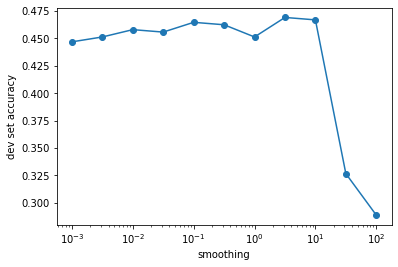

In [295]:
plt.semilogx(list(scores.keys()),list(scores.values()),'o-');
plt.xlabel('smoothing')
plt.ylabel('dev set accuracy');

**Reflect:**

- what might explain the dramatic drop in accuracy when the smoothing is increased from $10$ to $30$?
- before you check, predict whether the accuracy will continue to significantly drop if you further increase the smoothing to $10000$.

**My answer**

* Because our corpora of song lyrics only have a very limited number of words, for a particular label, the total number of words in our corpora of song lyrics that labeled as this specific label is also limited, when add the product of the smoothing and number of words (V), the denominator will become very large. Therefore, the probability of a specific word given a particular label will decrease and this will lower the accuracy.


* I predict that the accuracy will continue to significantly drop if I further increase the smoothing to  10000. Since 10000 is a very large number, and when it times the number of words (V), the denominator will become very large.

In [296]:
theta_nb = naive_bayes.estimate_nb(x_tr_pruned,y_tr,best_smoother)
y_hat = clf_base.predict_all(x_te_pruned,theta_nb,labels)
evaluation.write_predictions(y_hat,'nb-best-test.preds')

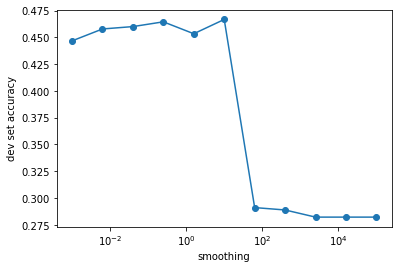

In [298]:
vals = np.logspace(-3,5,11)
best_smoother, scores = naive_bayes.find_best_smoother(x_tr_pruned,y_tr,x_dv_pruned,y_dv,vals)
plt.semilogx(list(scores.keys()),list(scores.values()),'o-');
plt.xlabel('smoothing')
plt.ylabel('dev set accuracy');

**Test Results**

In [297]:
! nosetests tests/test_classifier.py:test_d3_1_corpus_counts
! nosetests tests/test_classifier.py:test_d3_2_pxy    
! nosetests tests/test_classifier.py:test_d3_3a_nb
! nosetests tests/test_classifier.py:test_d3_4a_nb_best

.
----------------------------------------------------------------------
Ran 1 test in 29.303s

OK
.
----------------------------------------------------------------------
Ran 1 test in 36.405s

OK
.
----------------------------------------------------------------------
Ran 1 test in 38.529s

OK
.
----------------------------------------------------------------------
Ran 1 test in 45.738s

OK


# 4. Logistic regression

Total: 30 points

You will implement logistic regression in PyTorch.

## 4.1 Converting data to numpy

Numpy is a package for numerical computing in python.

You will need to convert your bag-of-words list of counters to a numpy array. 

- **Deliverable 4.1**: Implement `preproc.py:make_numpy()` (6 points)
- **Test**: `test_pytorch/test_d5_1_numpy`
- **Hint**: one approach is to start with `numpy.zeros((height,width))`, and then fill in the cells by iterating through the bag-of-words list

In [121]:
X = np.zeros((4,2))
print(X)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [299]:
X[1,1] = -1
X[2,0] = 1.5
print(X)

[[ 0.   0. ]
 [ 0.  -1. ]
 [ 1.5  0. ]
 [ 0.   0. ]]


In [312]:
reload(preproc);

In [313]:
X_tr = preproc.make_numpy(x_tr_pruned,vocab)
X_dv = preproc.make_numpy(x_dv_pruned,vocab)
X_te = preproc.make_numpy(x_te_pruned,vocab)

In [314]:
label_set = sorted(list(set(y_tr)))
print(label_set)

['1980s', '1990s', '2000s', 'pre-1980']


In [315]:
Y_tr = np.array([label_set.index(y_i) for y_i in y_tr])
Y_dv = np.array([label_set.index(y_i) for y_i in y_dv])

In [316]:
len(set(Y_tr))

4

## 4.2 Building a logistic regression model

- **Deliverable 4.2**: Complete `logreg.build_linear` (6 points)
- **Test**: `tests/test_pytorch.py:test_d5_2_logreg`

In [321]:
from gtnlplib import logreg
reload(logreg);

In [322]:
torch.manual_seed(765);

In [323]:
X_tr_var = Variable(torch.from_numpy(X_tr.astype(np.float32)))
X_dv_var = Variable(torch.from_numpy(X_dv.astype(np.float32)))
X_te_var = Variable(torch.from_numpy(X_te.astype(np.float32)))

It's always a good idea to check the dimensions of your data first.

In [324]:
print(X_tr_var.size())
print(X_dv_var.size())

torch.Size([4000, 4875])
torch.Size([450, 4875])


In [325]:
model = logreg.build_linear(X_tr,Y_tr)

In [326]:
scores = model.forward(X_dv_var)
print(scores)

tensor([[-0.7673, -0.7583, -0.3767,  0.0325],
        [ 0.1110, -0.3801, -0.3979,  0.1642],
        [-1.8015, -0.5595, -3.5092,  0.9633],
        ...,
        [-0.3965,  0.0962, -0.4972, -0.1959],
        [-0.1721, -0.5167, -0.2574,  0.1571],
        [-0.3643,  0.0312, -0.4181,  0.4564]], grad_fn=<AddmmBackward>)


## 4.3 Adding a log-softmax layer

We're done it for you in PyTorch. Write your own log-softmax function in numpy and verify the results.

- **Deliverable 4.3**: Complete `logreg.log_softmax` (6 points)
- **Test**: `tests/test_pytorch.py:test_d5_3_log_softmax`

In [328]:
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))

In [329]:
model.forward(X_dv_var)[:3]

tensor([[-1.7426, -1.7336, -1.3520, -0.9427],
        [-1.1841, -1.6752, -1.6930, -1.1309],
        [-3.0214, -1.7793, -4.7291, -0.2566]], grad_fn=<SliceBackward>)

In [330]:
model.forward(X_dv_var)[:3].exp()

tensor([[0.1751, 0.1767, 0.2587, 0.3896],
        [0.3060, 0.1873, 0.1840, 0.3227],
        [0.0487, 0.1688, 0.0088, 0.7737]], grad_fn=<ExpBackward>)

Notice that each row sums up to one.

In [331]:
model.forward(X_dv_var)[:3].exp().sum(dim=1)

tensor([1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

In [332]:
reload(logreg);

In [333]:
logreg.log_softmax(scores[:3].data.numpy()) 

array([[-1.7426362 , -1.7335784 , -1.3519608 , -0.9427422 ],
       [-1.1840885 , -1.675237  , -1.692963  , -1.1309158 ],
       [-3.0213726 , -1.7793286 , -4.7291145 , -0.25659704]],
      dtype=float32)

These should be very close to the PyTorch results.

## 4.4 Negative Log-Likelihood Loss

A loss function tells you how well your model is doing. It produces gradients that allows the optimizer to tune the model weights. We've done the Pytorch call for you, try implementing this yourself in numpy!

- **Deliverable 4.4**: Complete `logreg.nll_loss` (6 points)
- **Test**: `tests/test_pytorch.py:test_d5_4_nll_loss`

In [335]:
loss = torch.nn.NLLLoss()

In [336]:
Y_tr_var = Variable(torch.from_numpy(Y_tr))
Y_dv_var = Variable(torch.from_numpy(Y_dv))

In [337]:
logP = model.forward(X_tr_var)
print(loss.forward(logP,Y_tr_var))

tensor(1.5013, grad_fn=<NllLossBackward>)


In [338]:
reload(logreg);

In [339]:
logreg.nll_loss(logP.data.numpy(), Y_tr)

1.5013313

Again, This should be very similar to the PyTorch result above.

## 4.5 Putting everything together

An optimizer can be used to actually learn the weights. We provide the complete code below that you can train on in `logreg.train_model`.

In [366]:
reload(logreg);

In [357]:
# build a new model with a fixed seed
torch.manual_seed(765)
model = logreg.build_linear(X_tr,Y_tr)
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))

In [358]:
model_trained, losses, accuracies = logreg.train_model(loss,model,
                                                       X_tr_var,
                                                       Y_tr_var,
                                                       X_dv_var=X_dv_var,
                                                       Y_dv_var = Y_dv_var,
                                                       num_its=100,
                                                       optim_args={'lr':0.02})

Epoch 1: Dev Accuracy: 0.2822222222222222
Epoch 11: Dev Accuracy: 0.29555555555555557
Epoch 21: Dev Accuracy: 0.29555555555555557
Epoch 31: Dev Accuracy: 0.31333333333333335
Epoch 41: Dev Accuracy: 0.31777777777777777
Epoch 51: Dev Accuracy: 0.35777777777777775
Epoch 61: Dev Accuracy: 0.41333333333333333
Epoch 71: Dev Accuracy: 0.3488888888888889
Epoch 81: Dev Accuracy: 0.35333333333333333
Epoch 91: Dev Accuracy: 0.34444444444444444


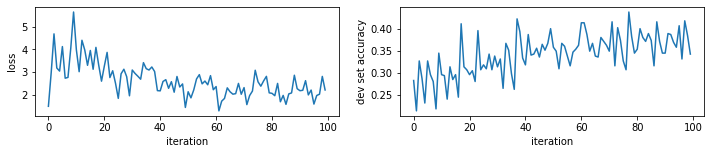

In [359]:
logreg.plot_results(losses,accuracies)

**Deliverable 4.5**
The noisy progress of the loss and dev set accuracy suggests that something is wrong with our hyperparameters. Tune the inputs to `train_model` until you can get to a dev set accuracy of at least 0.5. (6 points)

In [367]:
# build a new model with a fixed seed
torch.manual_seed(765)
model = logreg.build_linear(X_tr,Y_tr)
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))

In [368]:
model_trained, losses, accuracies = logreg.train_model(loss,model,
                                                       X_tr_var,
                                                       Y_tr_var,
                                                       X_dv_var=X_dv_var,
                                                       Y_dv_var = Y_dv_var,
                                                       num_its=5000,
                                                       optim_args={'lr':0.005})

Epoch 1: Dev Accuracy: 0.2822222222222222
Epoch 11: Dev Accuracy: 0.32666666666666666
Epoch 21: Dev Accuracy: 0.35555555555555557
Epoch 31: Dev Accuracy: 0.3688888888888889
Epoch 41: Dev Accuracy: 0.4
Epoch 51: Dev Accuracy: 0.41555555555555557
Epoch 61: Dev Accuracy: 0.42444444444444446
Epoch 71: Dev Accuracy: 0.4266666666666667
Epoch 81: Dev Accuracy: 0.42444444444444446
Epoch 91: Dev Accuracy: 0.4311111111111111
Epoch 101: Dev Accuracy: 0.43777777777777777
Epoch 111: Dev Accuracy: 0.4444444444444444
Epoch 121: Dev Accuracy: 0.4444444444444444
Epoch 131: Dev Accuracy: 0.45111111111111113
Epoch 141: Dev Accuracy: 0.45111111111111113
Epoch 151: Dev Accuracy: 0.45555555555555555
Epoch 161: Dev Accuracy: 0.45555555555555555
Epoch 171: Dev Accuracy: 0.4533333333333333
Epoch 181: Dev Accuracy: 0.45555555555555555
Epoch 191: Dev Accuracy: 0.4533333333333333
Epoch 201: Dev Accuracy: 0.4533333333333333
Epoch 211: Dev Accuracy: 0.4577777777777778
Epoch 221: Dev Accuracy: 0.4622222222222222
Epo

Epoch 1881: Dev Accuracy: 0.5155555555555555
Epoch 1891: Dev Accuracy: 0.5133333333333333
Epoch 1901: Dev Accuracy: 0.5133333333333333
Epoch 1911: Dev Accuracy: 0.5133333333333333
Epoch 1921: Dev Accuracy: 0.5133333333333333
Epoch 1931: Dev Accuracy: 0.5155555555555555
Epoch 1941: Dev Accuracy: 0.5155555555555555
Epoch 1951: Dev Accuracy: 0.5155555555555555
Epoch 1961: Dev Accuracy: 0.5155555555555555
Epoch 1971: Dev Accuracy: 0.5155555555555555
Epoch 1981: Dev Accuracy: 0.5155555555555555
Epoch 1991: Dev Accuracy: 0.5155555555555555
Epoch 2001: Dev Accuracy: 0.5155555555555555
Epoch 2011: Dev Accuracy: 0.5133333333333333
Epoch 2021: Dev Accuracy: 0.5133333333333333
Epoch 2031: Dev Accuracy: 0.5133333333333333
Epoch 2041: Dev Accuracy: 0.5133333333333333
Epoch 2051: Dev Accuracy: 0.5133333333333333
Epoch 2061: Dev Accuracy: 0.5111111111111111
Epoch 2071: Dev Accuracy: 0.5133333333333333
Epoch 2081: Dev Accuracy: 0.5133333333333333
Epoch 2091: Dev Accuracy: 0.5111111111111111
Epoch 2101

Epoch 3711: Dev Accuracy: 0.5133333333333333
Epoch 3721: Dev Accuracy: 0.5133333333333333
Epoch 3731: Dev Accuracy: 0.5133333333333333
Epoch 3741: Dev Accuracy: 0.5133333333333333
Epoch 3751: Dev Accuracy: 0.5133333333333333
Epoch 3761: Dev Accuracy: 0.5133333333333333
Epoch 3771: Dev Accuracy: 0.5133333333333333
Epoch 3781: Dev Accuracy: 0.5133333333333333
Epoch 3791: Dev Accuracy: 0.5133333333333333
Epoch 3801: Dev Accuracy: 0.5133333333333333
Epoch 3811: Dev Accuracy: 0.5133333333333333
Epoch 3821: Dev Accuracy: 0.5133333333333333
Epoch 3831: Dev Accuracy: 0.5133333333333333
Epoch 3841: Dev Accuracy: 0.5133333333333333
Epoch 3851: Dev Accuracy: 0.5133333333333333
Epoch 3861: Dev Accuracy: 0.5133333333333333
Epoch 3871: Dev Accuracy: 0.5133333333333333
Epoch 3881: Dev Accuracy: 0.5133333333333333
Epoch 3891: Dev Accuracy: 0.5133333333333333
Epoch 3901: Dev Accuracy: 0.5133333333333333
Epoch 3911: Dev Accuracy: 0.5133333333333333
Epoch 3921: Dev Accuracy: 0.5133333333333333
Epoch 3931

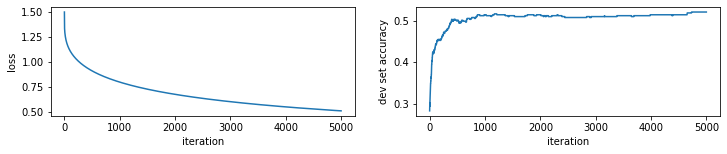

In [369]:
logreg.plot_results(losses,accuracies)

In [370]:
_, Y_hat_dv = model_trained.forward(X_dv_var).max(dim=1)
np.save('logreg-es-dev.preds.npy', Y_hat_dv.data.numpy())

In [371]:
acc = evaluation.acc(np.load('logreg-es-dev.preds.npy'),Y_dv_var.data.numpy())
print(acc)

0.5222222222222223


In [372]:
_, Y_hat_te = model.forward(X_te_var).max(dim=1)
np.save('logreg-es-test.preds.npy', Y_hat_te.data.numpy())

**Test Results**

In [373]:
! nosetests tests/test_pytorch.py:test_d5_1_numpy
! nosetests tests/test_pytorch.py:test_d5_2_logreg
! nosetests tests/test_pytorch.py:test_d5_3_log_softmax
! nosetests tests/test_pytorch.py:test_d5_4_nll_loss

.
----------------------------------------------------------------------
Ran 1 test in 52.028s

OK
.
----------------------------------------------------------------------
Ran 1 test in 46.919s

OK
.
----------------------------------------------------------------------
Ran 1 test in 49.970s

OK
.
----------------------------------------------------------------------
Ran 1 test in 48.387s

OK


# 5. Feature analysis

Total: 10 points


## 5.1 Top Features for Logistic Regression

- **Deliverable 5.1**: Implement ```get_top_features_for_label_torch``` in ```features.py```. (10 points)
- **Test**: `tests/test_features.py:test_d6_2_topfeat_torch`

**Hint**: Extract linear layer weights from the PyTorch model.

In [442]:
from gtnlplib import features
reload(features);

Load a fixed model so we have reproducible results. Feel free to change it to your own model.

In [443]:
model_test = torch.load('tests/test_weights.torch')

In [444]:
features.get_top_features_for_label_torch(model_test, vocab, label_set,'pre-1980',5)

['love', 'lovin', 'and', 'baby', 'on']

In [445]:
features.get_top_features_for_label_torch(model_test, vocab, label_set,'1990s',7)

['here', 'power', 'jam', 'saw', 'yeah', 'want', 'yall']

**Test Results**

In [447]:
! nosetests tests/test_features.py:test_d6_2_topfeat_torch

/Users/yuchengjin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/yuchengjin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/yuchengjin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LogSoftmax' has changed. you can retrieve the original sou

# 6. Precision, Recall, and F1 (Bonus question)

Besides accuracy, systems in natural language processing are evaluated using precision, recall, and F1. Such measures are essential when evaluating on an unbalanced dataset in terms of classes (labels). Write a function below that takes in a predicted labels 'Y_hat' and gold labels 'Y', and returns the precision, recall, and F1.

Total: 20 points

In [517]:
# This calculates the unweighted precision, recall, and f1 score.
# The unweighted precision, recall, and f1 score are obtained by calculating the precision, recall, and 
# f1 score of each label respectively, and take the unweighted averages of them.
def get_PRF(Y_hat, Y):
    #your code goes here
    Y_hat = np.array(Y_hat)
    Y = np.array(Y)
    labels = set(Y_hat) and set(Y)
    total = len(Y)
    support = {}
    actual = {}
    pred_right = {}
    for label in labels:
        support[label] = np.count_nonzero(Y_hat == label)
        actual[label] = np.count_nonzero(Y == label)
    for i in range(len(Y_hat)):
        if Y_hat[i] == Y[i]:
            if Y_hat[i] not in pred_right.keys():
                pred_right[Y_hat[i]] = 1
            else:
                pred_right[Y_hat[i]] += 1
    Precision = {}
    Recall = {}
    F1 = {}
    for label in labels:
        Precision[label] = pred_right[label]/support[label]
        Recall[label] = pred_right[label]/actual[label]
        F1[label] = 2 * Precision[label] * Recall[label] / (Precision[label] + Recall[label])
    precision = sum(Precision.values())/len(labels)
    recall = sum(Recall.values())/len(labels)
    f1 = sum(F1.values())/len(labels)
    return precision, recall, f1

In [518]:
print(get_PRF(Y_hat_dv, Y_dv))

(0.5012451765737741, 0.5042070698007792, 0.49997087710117516)


**Test the results of my algorithm with the results of sklearn.metrics.precision_score, sklearn.metrics.recall_score, and sklearn.metrics.f1_score**

In [520]:
print("Precision:",metrics.precision_score(Y_dv, Y_hat_dv, average = 'macro'))
print("Recall:",metrics.recall_score(Y_dv, Y_hat_dv, average = 'macro'))
print("F1:",metrics.f1_score(Y_dv, Y_hat_dv, average = 'macro'))
if get_PRF(Y_hat_dv, Y_dv) == (metrics.precision_score(Y_dv, Y_hat_dv, average = 'macro'),
                              metrics.recall_score(Y_dv, Y_hat_dv, average = 'macro'),
                              metrics.f1_score(Y_dv, Y_hat_dv, average = 'macro')):
    print("Test passed for unweighted precision, recall, and f1 score.")

Precision: 0.5012451765737741
Recall: 0.5042070698007792
F1: 0.49997087710117516
Test passed for unweighted precision, recall, and f1 score.


In [525]:
# This calculates the weighted precision, recall, and f1 score.
# The weighted precision, recall, and f1 score are obtained by calculating the precision, recall, and 
# f1 score of each label respectively, and take the weighted averages of them.
def get_PRF_weighted(Y_hat, Y):
    #your code goes here
    Y_hat = np.array(Y_hat)
    Y = np.array(Y)
    labels = set(Y_hat) and set(Y)
    total = len(Y)
    support = {}
    actual = {}
    pred_right = {}
    for label in labels:
        support[label] = np.count_nonzero(Y_hat == label)
        actual[label] = np.count_nonzero(Y == label)
    for i in range(len(Y_hat)):
        if Y_hat[i] == Y[i]:
            if Y_hat[i] not in pred_right.keys():
                pred_right[Y_hat[i]] = 1
            else:
                pred_right[Y_hat[i]] += 1
    Precision = {}
    Recall = {}
    F1 = {}
    for label in labels:
        Precision[label] = pred_right[label]/support[label]
        Recall[label] = pred_right[label]/actual[label]
        F1[label] = 2 * Precision[label] * Recall[label] / (Precision[label] + Recall[label])
    precision = 0
    recall = 0
    f1 = 0
    for label in labels:
        precision += Precision[label] * actual[label] / total
        recall += Recall[label] * actual[label] / total
        f1 += F1[label] * actual[label] / total
    return precision, recall, f1

In [526]:
print(get_PRF_weighted(Y_hat_dv, Y_dv))

(0.5108404846525847, 0.5222222222222223, 0.5138266534538458)


**Test the results of my algorithm with the results of sklearn.metrics.precision_score, sklearn.metrics.recall_score, and sklearn.metrics.f1_score**

In [530]:
from sklearn import metrics
print("Precision:",metrics.precision_score(Y_dv, Y_hat_dv, average = 'weighted'))
print("Recall:",metrics.recall_score(Y_dv, Y_hat_dv, average = 'weighted'))
print("F-1:", metrics.f1_score(Y_dv, Y_hat_dv, average = 'weighted'))
if get_PRF_weighted(Y_hat_dv, Y_dv) == (metrics.precision_score(Y_dv, Y_hat_dv, average = 'weighted'),
                              metrics.recall_score(Y_dv, Y_hat_dv, average = 'weighted'),
                              metrics.f1_score(Y_dv, Y_hat_dv, average = 'weighted')):
    print("Test passed for weighted precision, recall, and f1 score.")

Precision: 0.5108404846525847
Recall: 0.5222222222222223
F-1: 0.5138266534538458
Test passed for weighted precision, recall, and f1 score.
